# Street processing


The goal of this file is to
* Process the 1836 dataset (finding / working with duplicate streets)
* Define which streets belong to only one or both datasets
* Have one final dataset containing all georeferenced streets

In [1]:
# Imports
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import geopandas as gpd
#import contextily as cx
import matplotlib.pyplot as plt
from shapely.ops import linemerge, Point
#from shapely.errors import ShapelyDeprecationWarning
import warnings
#warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
#from importnb import Notebook
from preprocessing import preprocess
from collections import Counter
from duplicate_methods import duplicate_processing, duplicate_final

In [2]:
# Import shapefiles
Openparis = gpd.read_file("data/voie.zip", encoding = 'utf-8')
Vasserot = gpd.read_file("data/vasserot.zip")

# Set right EPSG for Geodata
Openparis = Openparis.to_crs(epsg=3857)
Vasserot = Vasserot.to_crs(epsg=3857)

#change mistakes in streetnames
mask = Vasserot.loc[:,"NOM_ENTIER"] == "Rue Lafayette"
Vasserot.loc[mask,["NOM","NOM_ENTIER"]] = ["la Fayette", "Rue la Fayette"]


In [22]:
Vasserot.dtypes

ROWID                 int64
ID_ALPAGE            object
TYPE                 object
NOM                  object
REF_SCAN             object
REF_SCAN2            object
ARTICLE              object
NOM2_SCAN2           object
NOM_ENTIER           object
CODE_FIAB            object
IDENTIFI              int64
STYLE                object
CSS_CLASS            object
EXTRA                object
geometry           geometry
NOM_ENTIER_prep      object
voie                 object
year                 object
buffer             geometry
dtype: object

## Preprocess streets with leas code

In [3]:
Openparis = preprocess(Openparis, "l_longmin")
Vasserot = preprocess(Vasserot, "NOM_ENTIER")

# TODO Rename those streets
Vasserot["voie"] = Vasserot["NOM_ENTIER_prep"]
Openparis["voie"] = Openparis["l_longmin_prep"]

# Remove empty lines
Vasserot = Vasserot.dropna(subset=["voie"])

# Add year
Vasserot = Vasserot.assign(year= [[1836]]*len(Vasserot))
Openparis = Openparis.assign(year= [[2022]]*len(Openparis))

# create buffer around streets, important for merging duplicate streets
buffer = 100
Vasserot["buffer"] = Vasserot["geometry"].apply(lambda x: x.buffer(buffer))
Openparis["buffer"] = Openparis["geometry"].apply(lambda x: x.buffer(buffer))



# Find all duplicates
Duplicates = Vasserot[Vasserot.duplicated(subset=['voie'], keep=False)].sort_values("voie")
Unique = Vasserot[~Vasserot.duplicated(subset=['voie'], keep=False)].sort_values("voie")



## Process 1836 streets

### Duplicate work

#### Merge duplicates if close ("Overlapping" streets)

In [4]:
DuplicatesProcessed = duplicate_processing(Duplicates, "voie")

# Sanity check if all streetnames are in the newly created dataframe
#len(Duplicates["voie"].unique()) == DuplicatesProcessed["voie"].unique()))

c:\Users\Ben\doc\uni\22HS\FDH\paris\duplicate_methods.py:55: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  Dataframe["matching"] = pd.np.empty((len(Dataframe), 0)).tolist()
c:\Users\Ben\miniconda3\envs\paris\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\Ben\miniconda3\envs\paris\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\Ben\miniconda3\envs\paris\lib\site-packages\pandas\core\dtypes\cast.py:1983: ShapelyDeprecationWarning: __len__ for multi-part geometries is depreca

In [5]:
DuplicatesProcessed = gpd.GeoDataFrame(DuplicatesProcessed)

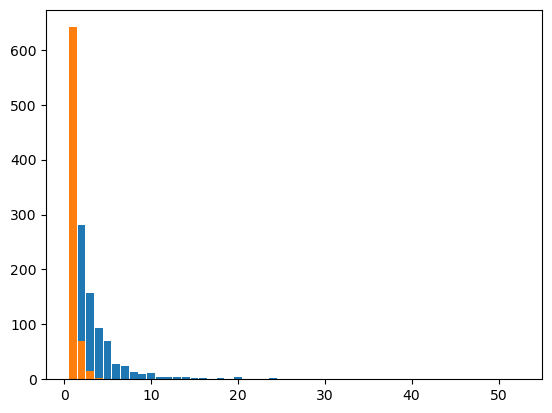

Duplicates before:  729
Duplicates after:  88


In [6]:
freqs = Counter(Duplicates["voie"].value_counts())
plt.bar(freqs.keys(), freqs.values(), width = 0.9)
freqs = Counter(DuplicatesProcessed["voie"].value_counts())
plt.bar(freqs.keys(), freqs.values(), width = 0.9)
plt.show()

print("Duplicates before: ", sum(Duplicates["voie"].value_counts()>1))
print("Duplicates after: ", sum(DuplicatesProcessed["voie"].value_counts()>1))

In [7]:
StillDuplicates = DuplicatesProcessed[DuplicatesProcessed.duplicated(subset=['voie'], keep=False)].sort_values("voie")
NewlyUnique = DuplicatesProcessed[~DuplicatesProcessed.duplicated(subset=['voie'], keep=False)].sort_values("voie")
# Adding newly unique streets
Unique = pd.concat([Unique, NewlyUnique])

#### Visualizing Streets that are still duplicates

In [8]:
# Needed in order to visualize results
StillDuplicates = StillDuplicates.drop(columns=["buffer"])

In [9]:
# Select Street to visualize
a = StillDuplicates["voie"].value_counts()[StillDuplicates["voie"].value_counts()>=2]
Trueduplicates = a.index
mask = StillDuplicates["voie"] == Trueduplicates[8]
# Visualize
#StillDuplicates[mask].explore()
StillDuplicates.explore()

 
## Find matching streets of both datasets


#### Preparing Vasserot and Openparis dataframe for final comparison

In [10]:
Unique.head(3)

ROWID ID_ALPAGE    TYPE        NOM        REF_SCAN REF_SCAN2 ARTICLE  \
2374  2375    TR2375   Allée   Marboeuf  ADO75CA_ANO069      None    None   
1082  1083    TR1083  Avenue    Arsenal  ADO75CA_ANO586      None   de l'   
1073  1074    TR1074  Avenue  Triomphes  ADO75CA_ANO572      None     des   

     NOM2_SCAN2            NOM_ENTIER CODE_FIAB  ...  \
2374       None        Allée Marboeuf         1  ...   
1082       None   Avenue de l'Arsenal         1  ...   
1073       None  Avenue des Triomphes         1  ...   

                                                  STYLE CSS_CLASS EXTRA  \
2374  fill:none;stroke:#000000;stroke-opacity:0.7;st...     x1L86     _   
1082  fill:none;stroke:#000000;stroke-opacity:0.7;st...     x1L86     _   
1073  fill:none;stroke:#000000;stroke-opacity:0.7;st...     x1L86     _   

                                               geometry       NOM_ENTIER_prep  \
2374  LINESTRING (256709.197 6252932.608, 256668.651...        allee marboeuf   
1082  LINESTRING (263598.227 6249748.699, 263556.945...   avenue de l'arsenal   
1073  LINESTRING (267115.878 6249542.645, 267078.529...  avenue des triomphes   

                      voie    year  \
2374        allee marboeuf  [1836]   
1082   avenue de l'arsenal  [1836]   
1073  avenue des triomphes  [1836]   

                                                 buffer matching filter  
2374  POLYGON ((256244.55925113952 6252420.978989364...      NaN    NaN  
1082  POLYGON ((263638.58308824815 6249632.589941799...      NaN    NaN  
1073  POLYGON ((267154.137176694 6249434.068389154, ...      NaN    NaN  

[3 rows x 21 columns]

In [11]:
# Unique from Vasserot DF
Unique = Unique.iloc[:,[0,2,3,6,8,14,16,17,18]]
Unique = Unique.rename(columns={"ROWID":"rowid", "NOM_ENTIER":"streetname","TYPE":"type","ARTICLE":"article","NOM":"name", "voie":"streetname_prep"})
Unique = Unique.assign(matching = [[]] * len(Unique))

In [12]:
Openparis.head(3)

n_sq_vo  c_coinsee c_desi c_liaison      l_voie         l_courtmin  \
0  750004036.0    75056.0    ALL        D'  ANDREZIEUX  All. d'Andrézieux   
1  750004037.0    75056.0    RUE      None    ANDROUET        R. Androuet   
2  750005021.0    75056.0    RUE       DES     ANGLAIS     R. des Anglais   

            l_longmin     c_voie b_fantoir b_off c_voie_vp  objectid c_domoff  \
0  Allée d'Andrézieux  750560334         O     O      0325       8.0        V   
1        Rue Androuet  750560339         O     O      0320      13.0        P   
2     Rue des Anglais  750560346         O     O      0327      19.0        P   

       n_sq_co      length                                           geometry  \
0  750001537.0  409.388415  MULTILINESTRING ((261929.132 6256604.215, 2619...   
1  750001537.0   45.836534  LINESTRING (260320.077 6255463.999, 260324.568...   
2  750001537.0  108.957050  LINESTRING (261403.233 6249619.659, 261394.210...   

       l_longmin_prep                voie    year  \
0  allee d'andrezieux  allee d'andrezieux  [2022]   
1        rue androuet        rue androuet  [2022]   
2     rue des anglais     rue des anglais  [2022]   

                                              buffer  
0  POLYGON ((261751.843 6256581.790, 261749.847 6...  
1  POLYGON ((260222.547 6255485.544, 260220.677 6...  
2  POLYGON ((261236.441 6249598.907, 261237.723 6...

In [13]:
# Uniques from Openparis DF
Openparis = Openparis.iloc[:,[2,3,4,5,6,15,17,18,19]]
Openparis = Openparis.rename(columns={"l_longmin": "streetname","c_desi":"type","c_liaison":"article","l_voie":"name","l_courtmin":"streetname_short","voie":"streetname_prep"})
# assign random rowid to Openparis data because they dont have them
Openparis = Openparis.assign(rowid = np.random.randint(7000, 200000, size=len(Openparis)))
Openparis = Openparis.assign(matching = [[]] * len(Openparis))

Merged = pd.concat([Unique, Openparis])
Merged


rowid    type             name article                  streetname  \
2374    2375   Allée         Marboeuf    None              Allée Marboeuf   
1082    1083  Avenue          Arsenal   de l'         Avenue de l'Arsenal   
1073    1074  Avenue        Triomphes     des        Avenue des Triomphes   
1680    1681  Avenue     Trois Frères     des     Avenue des Trois Frères   
1028    1029  Avenue          Bel Air      du           Avenue du Bel Air   
...      ...     ...              ...     ...                         ...   
6537   30249    VOIE            DI/19    None                  Voie Di/19   
6538   59688    VOIE             F/11    None                   Voie F/11   
6539   34420    VOIE            AW/14    None                  Voie Aw/14   
6540  153513    CHEM    CROIX CATELAN   DE LA  Chemin de la Croix Catelan   
6541  120783     RUE  PETITS CARREAUX     DES     Rue des Petits Carreaux   

                                               geometry  \
2374  LINESTRING (256709.197 6252932.608, 256668.651...   
1082  LINESTRING (263598.227 6249748.699, 263556.945...   
1073  LINESTRING (267115.878 6249542.645, 267078.529...   
1680  LINESTRING (263776.291 6250990.224, 263783.362...   
1028  LINESTRING (267057.188 6248665.633, 267041.820...   
...                                                 ...   
6537  LINESTRING (265842.047 6258079.918, 265850.032...   
6538  LINESTRING (263945.860 6252546.483, 263988.205...   
6539  LINESTRING (258726.087 6244468.096, 258595.856...   
6540  LINESTRING (251045.314 6252171.705, 251044.678...   
6541  LINESTRING (261284.204 6252214.460, 261300.753...   

                 streetname_prep    year  \
2374              allee marboeuf  [1836]   
1082         avenue de l'arsenal  [1836]   
1073        avenue des triomphes  [1836]   
1680     avenue des trois freres  [1836]   
1028           avenue du bel air  [1836]   
...                          ...     ...   
6537                  voie di/19  [2022]   
6538                   voie f/11  [2022]   
6539                  voie aw/14  [2022]   
6540  chemin de la croix catelan  [2022]   
6541     rue des petits carreaux  [2022]   

                                                 buffer matching  \
2374  POLYGON ((256244.55925113952 6252420.978989364...       []   
1082  POLYGON ((263638.58308824815 6249632.589941799...       []   
1073  POLYGON ((267154.137176694 6249434.068389154, ...       []   
1680  POLYGON ((263749.75761069637 6251086.930912063...       []   
1028  POLYGON ((266951.6992497895 6248654.251839547,...       []   
...                                                 ...      ...   
6537  POLYGON ((265751.37653612136 6258144.461011874...       []   
6538  POLYGON ((264081.99486991926 6252466.695427662...       []   
6539  POLYGON ((258482.33945777983 6244435.52150154,...       []   
6540  POLYGON ((251108.84518582484 6251888.475607082...       []   
6541  POLYGON ((261201.39849822526 6252370.697975336...       []   

               streetname_short  
2374                        NaN  
1082                        NaN  
1073                        NaN  
1680                        NaN  
1028                        NaN  
...                         ...  
6537                 Voie Di/19  
6538                  Voie F/11  
6539                 Voie Aw/14  
6540  Chem. de la Croix Catelan  
6541     R. des Petits Carreaux  

[7744 rows x 11 columns]

In [14]:
MergedProcessed = duplicate_final(Merged, "streetname_prep")

c:\Users\Ben\doc\uni\22HS\FDH\paris\duplicate_methods.py:98: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  Dataframe["matching"] = pd.np.empty((len(Dataframe), 0)).tolist()


In [15]:
MergedProcessed = preprocess(MergedProcessed, "name")

In [16]:
MergedProcessed.head(3)

rowid    type       name article            streetname  \
2374  2375   Allée   Marboeuf    None        Allée Marboeuf   
1082  1083  Avenue    Arsenal   de l'   Avenue de l'Arsenal   
1073  1074  Avenue  Triomphes     des  Avenue des Triomphes   

                                               geometry       streetname_prep  \
2374  LINESTRING (256709.197 6252932.608, 256668.651...        allee marboeuf   
1082  LINESTRING (263598.227 6249748.699, 263556.945...   avenue de l'arsenal   
1073  LINESTRING (267115.878 6249542.645, 267078.529...  avenue des triomphes   

        year                                             buffer matching  \
2374  [1836]  POLYGON ((256244.55925113952 6252420.978989364...   [2375]   
1082  [1836]  POLYGON ((263638.58308824815 6249632.589941799...   [1083]   
1073  [1836]  POLYGON ((267154.137176694 6249434.068389154, ...   [1074]   

     streetname_short filter  name_prep  
2374              NaN   True   marboeuf  
1082              NaN   True    arsenal  
1073              NaN   True  triomphes

In [17]:
FinalDuplicates = MergedProcessed[MergedProcessed.duplicated(subset=['streetname_prep'], keep=False)].sort_values("streetname_prep")
FinalUnique= MergedProcessed[~MergedProcessed.duplicated(subset=['streetname_prep'], keep=False)].sort_values("streetname_prep")


In [18]:
max(FinalUnique["streetname_prep"].value_counts())
FinalDuplicates
#UniqueProcessed["year"][800:900]


rowid    type              name article                  streetname  \
2794  151397      AV           NEUILLY      DE           Avenue de Neuilly   
2516    2517  Avenue           Neuilly      de           Avenue de Neuilly   
4070   23599      AV  MARECHAL FAYOLLE      DU  Avenue du Maréchal Fayolle   
3469  108516      AV  MARECHAL FAYOLLE      DU  Avenue du Maréchal Fayolle   
5350   32630      BD     SAINT-JACQUES    None     Boulevard Saint-Jacques   
...      ...     ...               ...     ...                         ...   
2474    2475     Rue            Samson    None                  Rue Samson   
5479   45201     RUE          VERDERET    None                Rue Verderet   
1892    1893     Rue          Verderet    None                Rue Verderet   
600      601     Rue          Voltaire    None                Rue Voltaire   
485   105513     RUE          VOLTAIRE    None                Rue Voltaire   

                                               geometry  \
2794  MULTILINESTRING ((253901.774 6254239.049, 2538...   
2516  LINESTRING (256394.854 6253080.177, 256403.035...   
4070  LINESTRING (253168.755 6253044.682, 253096.445...   
3469  LINESTRING (272359.887 6248736.842, 272341.331...   
5350  MULTILINESTRING ((260618.942 6246334.887, 2605...   
...                                                 ...   
2474  LINESTRING (263216.971 6252670.672, 263205.894...   
5479  LINESTRING (252535.611 6249000.995, 252507.422...   
1892  LINESTRING (261445.396 6251825.533, 261443.529...   
600   LINESTRING (260511.949 6249619.041, 260498.220...   
485   LINESTRING (266008.349 6249811.542, 266207.869...   

                 streetname_prep  \
2794           avenue de neuilly   
2516           avenue de neuilly   
4070  avenue du marechal fayolle   
3469  avenue du marechal fayolle   
5350     boulevard saint jacques   
...                          ...   
2474                  rue samson   
5479                rue verderet   
1892                rue verderet   
600                 rue voltaire   
485                 rue voltaire   

                                                   year  \
2794                                             [2022]   
2516  [1836, 1836, 1836, 1836, 1836, 1836, 1836, 183...   
4070                                             [2022]   
3469                                             [2022]   
5350                                             [2022]   
...                                                 ...   
2474                                             [1836]   
5479                                             [2022]   
1892                                             [1836]   
600                                              [1836]   
485                                              [2022]   

                                                 buffer  matching  \
2794  POLYGON ((253835.07666342898 6254160.547185495...  [151397]   
2516  POLYGON ((256447.5217521471 6253165.535525703,...    [2517]   
4070  POLYGON ((253168.72178909287 6252903.972542264...   [23599]   
3469  POLYGON ((272440.6119180152 6248585.651159191,...  [108516]   
5350  POLYGON ((259652.45515343707 6246720.420406748...   [32630]   
...                                                 ...       ...   
2474  POLYGON ((263249.6898084181 6252576.3033275185...    [2475]   
5479  POLYGON ((252417.22556890672 6248997.574815788...   [45201]   
1892  POLYGON ((261539.70669977096 6251791.592220424...    [1893]   
600   POLYGON ((260592.76598554218 6249546.640195917...     [601]   
485   POLYGON ((266172.4146549705 6249962.384158942,...  [105513]   

             streetname_short filter         name_prep  
2794           Av. de Neuilly   True           neuilly  
2516                      NaN  False           neuilly  
4070  Av. du Maréchal Fayolle   True  marechal fayolle  
3469  Av. du Maréchal Fayolle  False  marechal fayolle  
5350        Bd. Saint-Jacques   True     saint jacques  
...                       ...    ...            

In [19]:
FinalDuplicates= FinalDuplicates.drop(columns=["buffer"])
FinalDuplicates.explore()

In [20]:
FinalUnique["geometry"].explore()

# Saving Dataframes

In [23]:
FinalUnique = FinalUnique.convert_dtypes()
FinalDuplicates = FinalDuplicates.convert_dtypes()

FinalUnique.to_pickle("data/FinalUnique.pkl")
FinalDuplicates.to_pickle("data/FinalDuplicate.pkl")


# TODO: grouping on short streetnames 

old code:

In [30]:
# group streets based on their short name
grouped_streets = FinalUnique.groupby("name_prep", as_index=False).agg({"streetname": list, "year": list, "rowid": list})

# split streets in those that are unique and those that aren't
unique_short_streets = grouped_streets[grouped_streets['streetname'].str.len() == 1]
unique_short_streets[["streetname", "year", "rowid"]] = unique_short_streets[["streetname", "year", "rowid"]].apply(lambda x: x[0])
multiple_short_streets = grouped_streets[grouped_streets['streetname'].str.len() > 1]

print(f"#streets with unique short streetname: {len(unique_short_streets)}, not unique: {len(multiple_short_streets)}")
multiple_short_streets.head(3)

#streets with unique short streetname: 5374, not unique: 780


name_prep                                         streetname  \
18    abbaye              [Chemin de l'Abbaye, Rue de l'Abbaye]   
35  abbesses  [Passage des Abbesses, Place des Abbesses, Rue...   
50   acacias      [Passage des Acacias, Petite Rue des Acacias]   

                                        year                    rowid  
18  [[2022], [1836, 1836, 1836, 1836, 2022]]             [93692, 746]  
35                  [[2022], [2022], [2022]]  [33072, 192976, 149842]  
50              [[2022], [1836, 1836, 1836]]             [83919, 432]

In [31]:
unique_short_streets.to_pickle("data/unique_short_streets.pkl")
multiple_short_streets.to_pickle("data/not_unique_short_streets.pkl")